In [1]:
%matplotlib inline

import mapper

import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
import palettable as pltt
import pandas as pd
import numpy as np
import dionysus as d
from pysal.contrib.viz import mapping as maps

from seaborn import palplot
from mapper.mapper_output import fcluster
from scipy.spatial.distance import cdist, pdist, squareform
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA


Using cmappertools v1.0.24.


In [2]:
def distance_to_base_point(data, distance_metric='euclidean'):
    np.random.seed(44)
    sample_point = data.iloc[np.random.choice(data.shape[0],  1)[0]]
    distances_to_point = (data - sample_point).pow(2).sum(1).pow(0.5)
    basepoint = data.loc[distances_to_point.idxmax()]
    return (data - basepoint).pow(2).sum(1).pow(0.5)


def l_infinity_centrality(data, distance_metric='euclidean'):
    point_wise_distances = squareform(pdist(data, metric=distance_metric))
    distances = []
    for i in range(len(data)):
        distances.append(np.max(point_wise_distances[i,]))
    return np.array(distances)

def try_mapper(data, fd, hist_cutoff=15):
    
    data = np.array(data).astype(float)
    overlaps = [10, 20, 30, 40, 50, 60, 70, 80]

    graphs = []
    ints = []
    ovrs = []

    for intervals in range(3, 21):
        for overlap in overlaps:
            cover = mapper.cover.cube_cover_primitive(intervals, overlap)

            cutoff = mapper.cutoff.histogram(hist_cutoff)
            cluster = mapper.average_linkage()

            G = mapper.mapper(data, fd, cover, 
                      cutoff, cluster=cluster, verbose=0)

            graphs.append(G)
            ints.append(intervals)
            ovrs.append(overlap)
            
    return graphs


def print_ccs(graphs):
    c1 = find_cc_mapper_graphs(1, graphs)
    c2 = find_cc_mapper_graphs(2, graphs)
    c3 = find_cc_mapper_graphs(3, graphs)
    c4 = find_cc_mapper_graphs(4, graphs)
    c5 = find_cc_mapper_graphs(5, graphs)
    c6 = find_cc_mapper_graphs(6, graphs)
    print(c1,c2,c3,c4,c5,c6)
    
    
def print_ccs2(graphs):
    c1 = find_cc_mapper_graphs(7, graphs)
    c2 = find_cc_mapper_graphs(8, graphs)
    c3 = find_cc_mapper_graphs(9, graphs)
    c4 = find_cc_mapper_graphs(10, graphs)
    c5 = find_cc_mapper_graphs(11, graphs)
    c6 = find_cc_mapper_graphs(12, graphs)
    print(c1,c2,c3,c4,c5,c6)
    
def run_mapper(data, filtered_data, intervals, overlap, hist_cutoff, verbose=0):
    
    data = np.array(data).astype(float)
    cover = mapper.cover.cube_cover_primitive(intervals, overlap)
    cutoff = mapper.cutoff.histogram(hist_cutoff)
    cluster = mapper.single_linkage()
    G = mapper.mapper(data, filtered_data, cover, cutoff, cluster=cluster, verbose=verbose)
    return G


def test_filter(f, interval, overlap):
    from matplotlib.pyplot import cm 
        
    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    
    f1, ax1 = plt.subplots(1, figsize=(6, 6))
    
    color=iter(cm.rainbow(np.linspace(0,1,interval)))
    ax1.hist(f)

    for level in cover(f):
        c = next(color)
        ax1.axvline(x=level.range_min, color=c)
        ax1.axvline(x=level.range_max, color=c)

    plt.show()
    
    
def color_circle(data, f, interval, overlap):
    from matplotlib.pyplot import cm 
        
    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    
    f1, ax1 = plt.subplots(1, figsize=(6, 6))
    
    color = iter(cm.rainbow(np.linspace(0,1,interval)))

    for level in cover(f):
        
        lb = f >= level.range_min
        ub = f <= level.range_max
        indxs = np.logical_and(lb, ub)
        
        c = next(color)
        
        plt.scatter(data[indxs][:,0], 
                    data[indxs][:,1], color=c, alpha=0.5)
        
    plt.show()
    
    

def test_mapper_configuration(data, fd, interval, overlap, bins):

    cover = mapper.cover.cube_cover_primitive(interval, overlap)
    cutoff = mapper.cutoff.histogram(bins)
    
    data = np.array(data).astype(float)
    
    for level in cover(fd):

        lb = fd >= level.range_min
        ub = fd <= level.range_max
        indxs = np.logical_and(lb, ub)
        
        print (level)
        print('Number of points in level -', sum(indxs))

        part_data = pdist(data[indxs,:])
        R = part_data.max()
        Z = linkage(part_data)
        
        heights = Z[:,2]
        
        num_clust = cutoff(heights, R)
        
        bin_counts, bin_leftedges = np.histogram(heights,
                                                 bins=bins,
                                                 range=(0,R))        
        
        f1, ax1 = plt.subplots(1, figsize=(6, 6))
        ax1.bar(bin_leftedges[:-1] + np.diff(bin_leftedges) / 2, bin_counts, np.diff(bin_leftedges))
        
        for edge in bin_leftedges:
            ax1.axvline(x=edge, color='r')
        
# #         empty_bins_idx, = np.nonzero(bin_counts[:-1] == 0)
#         if empty_bins_idx.size:
#             print(empty_bins_idx)
    
        print('Clusters - ', num_clust)
        plt.show()


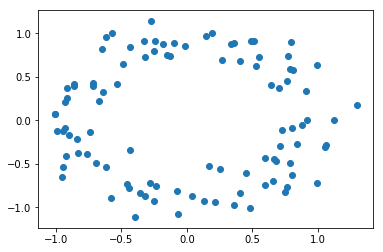

In [3]:
from sklearn.datasets import make_circles
x,_ = make_circles(n_samples=100, shuffle=True, noise=0.12, random_state=None, factor=0.8)
plt.scatter(x[:,0], x[:,1])

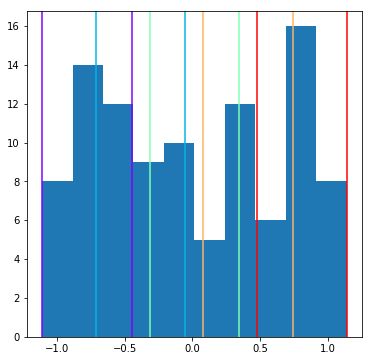

In [4]:
test_filter(x[:,1], 5, 40)

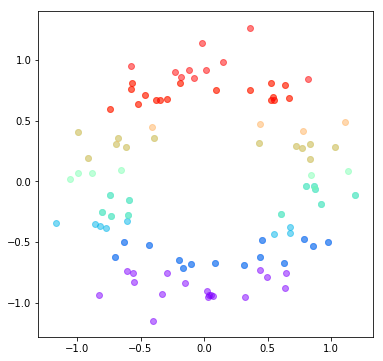

In [5]:
color_circle(x, x[:,1], 5, 40)

Filter level. Index: (0,), Range min: [-1.18245452], Range max: [-0.51854721]
Number of points in level - 30
Clusters -  1


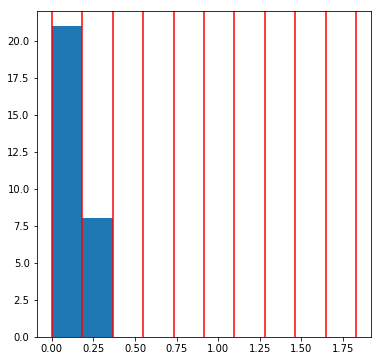

Filter level. Index: (1,), Range min: [-0.78411014], Range max: [-0.12020283]
Number of points in level - 33
Clusters -  1


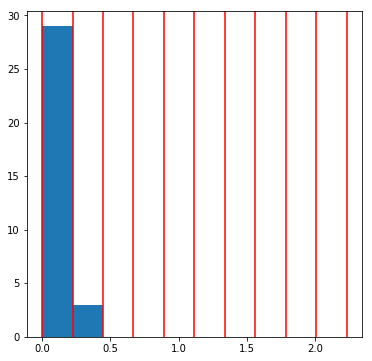

Filter level. Index: (2,), Range min: [-0.38576575], Range max: [0.27814156]
Number of points in level - 25
Clusters -  2


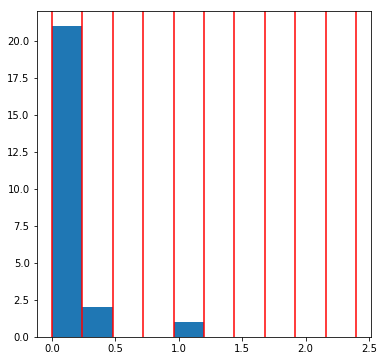

Filter level. Index: (3,), Range min: [0.01257863], Range max: [0.67648594]
Number of points in level - 26
Clusters -  1


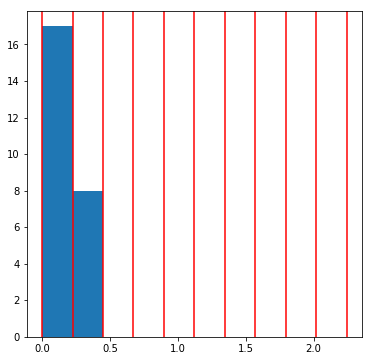

Filter level. Index: (4,), Range min: [0.41092302], Range max: [1.07483033]
Number of points in level - 35
Clusters -  1


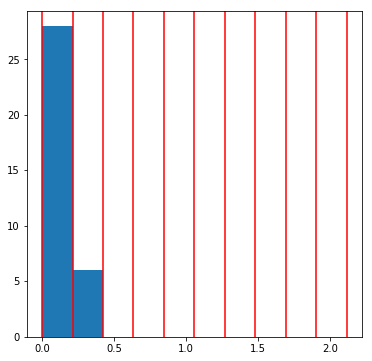

In [16]:
test_mapper_configuration(x, x[:,1], 5, 40, 10)

In [17]:
G = run_mapper(x, x[:,1], 5, 40, 10, verbose=0)

There are 6 nodes.


((-127.05458693745433,
  -48.21388770623882,
  126.20988034991635,
  49.3114024012565,
  0.28766738322983026),
 array([0, 1, 3, 2, 5, 4]),
 array([[  18.44897362,   49.3114024 ],
        [  56.4726757 ,  -20.48054724],
        [ -56.02898058,   21.67384119],
        [ 126.20988035,  -48.21388771],
        [ -18.05093531,  -48.21388771],
        [-127.05458694,   45.92380036]]),
 <matplotlib.collections.CircleCollection at 0x7f5e4c8d1d68>)

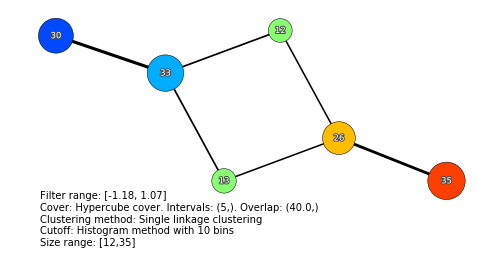

In [18]:
G.draw_2D()

In [44]:
norm_data = pd.read_csv('data/colorado/processed.csv')
norm_data.set_index('w_geocode', inplace=True)

Minimal epsilon: 5.97536.
Density of the adjacency matrix: 8.70%.
Eigenvalues: [-1.66498299e-16  2.01961704e-02].


(array([1055.,  651.,  566.,  631.,  619.,  691.,  799.,  935., 1194.,
        1468.]),
 array([-0.01898967, -0.01557418, -0.0121587 , -0.00874322, -0.00532773,
        -0.00191225,  0.00150323,  0.00491872,  0.0083342 ,  0.01174969,
         0.01516517]),
 <a list of 10 Patch objects>)

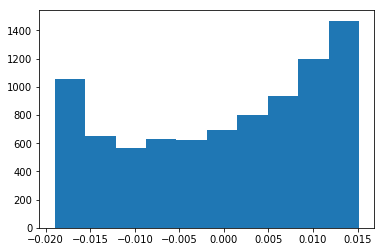

In [45]:
lap_filter = mapper.filters.graph_Laplacian(norm_data[['CE01','CE02', 'CE03']], eps=12)
plt.hist(lap_filter)

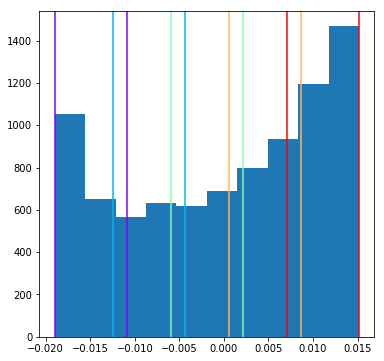

In [46]:
test_filter(norm_data, lap_filter, 5, 20)

Filter level. Index: (0,), Range min: [-0.01898967], Range max: [-0.01085756]
Number of points in level - 1901
Clusters -  2


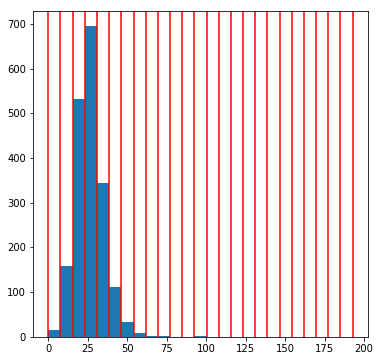

Filter level. Index: (1,), Range min: [-0.01248398], Range max: [-0.00435188]
Number of points in level - 1388
Clusters -  2


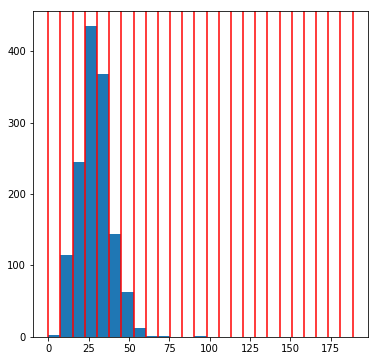

Filter level. Index: (2,), Range min: [-0.0059783], Range max: [0.0021538]
Number of points in level - 1593
Clusters -  1


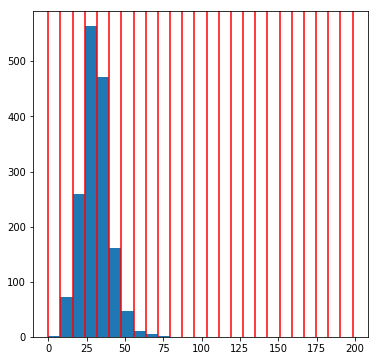

Filter level. Index: (3,), Range min: [0.00052738], Range max: [0.00865949]
Number of points in level - 2016
Clusters -  1


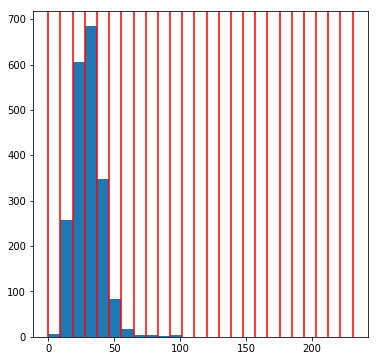

Filter level. Index: (4,), Range min: [0.00703307], Range max: [0.01516517]
Number of points in level - 3064
Clusters -  2


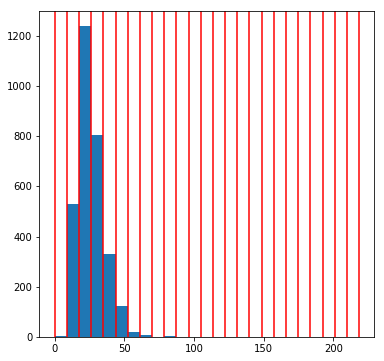

In [47]:
test_mapper_configuration(, lap_filter, 5, 20, 25)

There are 8 nodes.


((-130.17510115429502,
  -42.3377696634363,
  147.15972003549683,
  73.86069960463249,
  0.28766738322983026),
 array([0, 2, 5, 1, 3, 7, 4, 6]),
 array([[ -57.93895746,   21.32096512],
        [  13.83530221,   12.29982755],
        [-130.17510115,   20.26937197],
        [ -38.37443229,   73.8606996 ],
        [  82.95890981,   -9.07195485],
        [ 147.15972004,  -42.33776966],
        [  52.15148441,   71.61160991],
        [ -74.40102997,  -42.33776966]]),
 <matplotlib.collections.CircleCollection at 0x7f6d1842c2b0>)

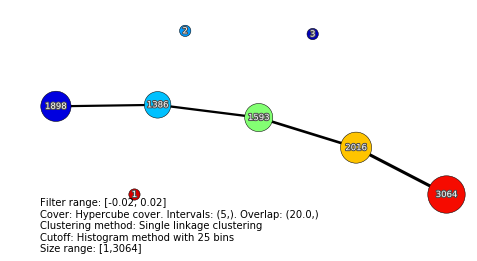

In [63]:
G = run_mapper(np.array(norm_data).astype(float), lap_filter, 5, 20, 25)
G.draw_2D()

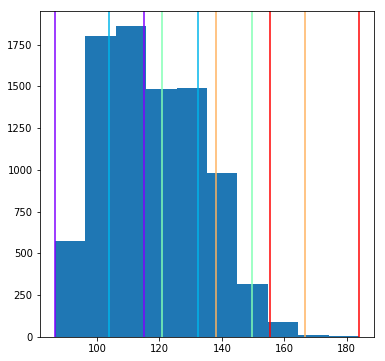

In [55]:
eccentricity_filter = mapper.filters.eccentricity(norm_data)
test_filter(eccentricity_filter, 5, 40)

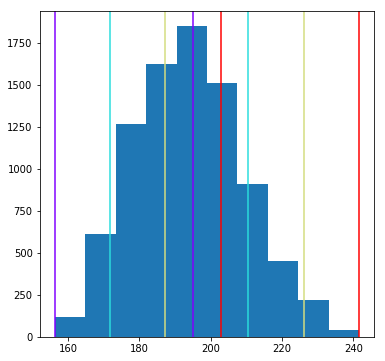

In [58]:
centrality_filter = l_infinity_centrality(norm_data)
test_filter(centrality_filter, 4, 60)

Filter level. Index: (0,), Range min: [156.32675467], Range max: [195.10077338]
Number of points in level - 4623
Clusters -  2


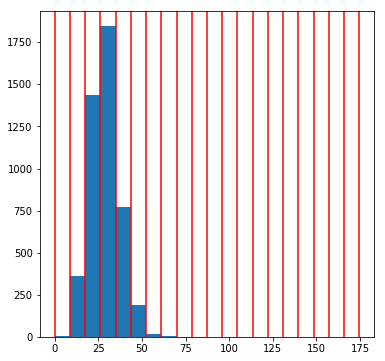

Filter level. Index: (1,), Range min: [171.83636215], Range max: [210.61038086]
Number of points in level - 6800
Clusters -  2


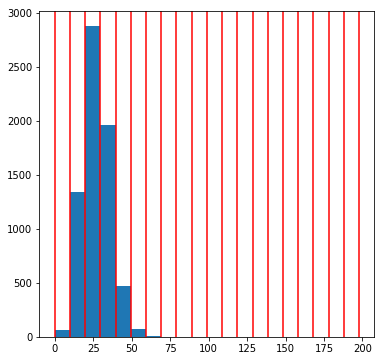

Filter level. Index: (2,), Range min: [187.34596964], Range max: [226.11998835]
Number of points in level - 5356
Clusters -  1


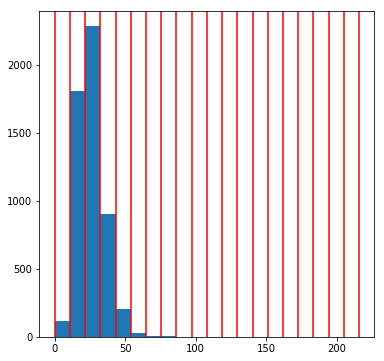

Filter level. Index: (3,), Range min: [202.85557712], Range max: [241.62959583]
Number of points in level - 2321
Clusters -  5


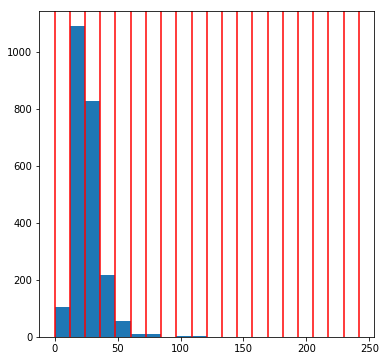

In [62]:
test_mapper_configuration(norm_data, centrality_filter, 4, 60, 20)

There are 8 nodes.


((-138.26185559179493,
  -69.9130203469069,
  122.21551083660333,
  60.14628531599973,
  0.28766738322983026),
 array([0, 2, 4, 1, 5, 3, 7, 6]),
 array([[ -67.15336617,   46.76067691],
        [  -1.84575866,   15.8452045 ],
        [-138.26185559,   60.14628532],
        [  -7.93291131,  -44.01214512],
        [  64.96204359,  -11.785977  ],
        [  57.10665098,  -69.91302035],
        [ 122.21551084,  -55.99674365],
        [  95.90841654,   60.14628532]]),
 <matplotlib.collections.CircleCollection at 0x7f6d0bd91c50>)

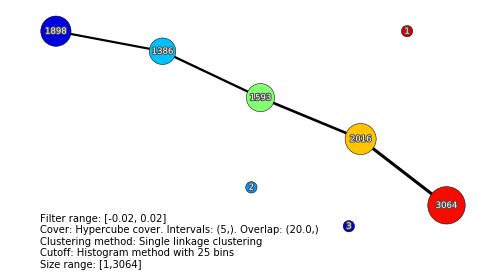

In [64]:
G = run_mapper(np.array(norm_data).astype(float), lap_filter, 5, 20, 25)
G.draw_2D()

In [67]:
data = pd.read_csv('data/colorado/processed.csv')
data.set_index('w_geocode', inplace=True)

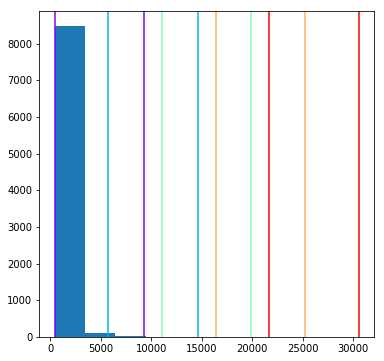

In [79]:
eccentricity_filter = mapper.filters.eccentricity(data)
test_filter(eccentricity_filter, 5, 40)

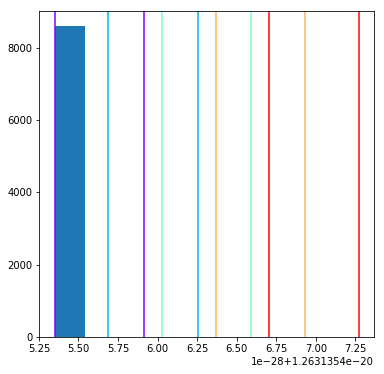

In [81]:
test_filter(mapper.filters.Gauss_density(data), 5, 40)

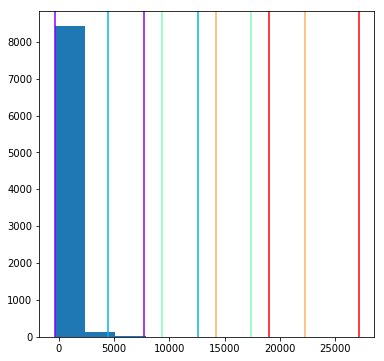

In [82]:
pca = PCA(n_components=2)
vals = pca.fit_transform(data)
test_filter(vals[:, 0],5, 40)

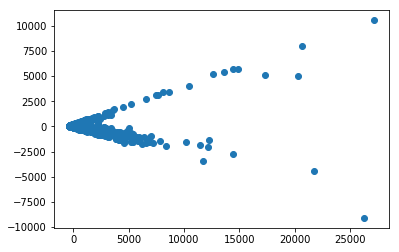

In [83]:
plt.scatter(vals[:, 0], vals[:, 1],)

In [7]:
data = pd.read_csv('data/colorado/norm_cleaned.csv')
data.set_index('w_geocode', inplace=True)

In [25]:
data.head()

CA01       CA02       CA03       CE01       CE02  \
w_geocode                                                               
80010078011007  18.918919  51.351351  29.729730  82.162162  14.594595   
80010078011008  16.326531  65.306122  18.367347  10.204082  38.775510   
80010078011013  15.789474  56.140351  28.070175  68.421053  26.315789   
80010078011014  46.296296  44.444444   9.259259  46.296296  38.888889   
80010078012008  24.390244  58.536585  17.073171  14.634146  65.853659   

                     CE03  CNS01  CNS02  CNS03  CNS04    ...          CR03  \
w_geocode                                                ...                 
80010078011007   3.243243    0.0    0.0    0.0    0.0    ...      0.540541   
80010078011008  51.020408    0.0    0.0    0.0    0.0    ...      0.000000   
80010078011013   5.263158    0.0    0.0    0.0    0.0    ...      0.000000   
80010078011014  14.814815    0.0    0.0    0.0    0.0    ...      9.259259   
80010078012008  19.512195    0.0    0.0    0.0    0.0    ...      0.000000   

                     CR04      CR05      CR07       CT01       CD01  \
w_geocode                                                             
80010078011007   3.243243  0.000000  1.081081  55.675676  25.945946   
80010078011008   0.000000  0.000000  2.040816  83.673469  12.244898   
80010078011013   5.263158  0.000000  1.754386  57.894737  24.561404   
80010078011014   0.000000  0.000000  1.851852  44.444444  12.962963   
80010078012008  48.780488  2.439024  0.000000  97.560976   9.756098   

                     CD02       CD03       CD04       CS01  
w_geocode                                                   
80010078011007  19.459459  21.621622  14.054054  30.270270  
80010078011008  20.408163  28.571429  22.448980  42.857143  
80010078011013  19.298246  28.070175  12.280702  14.035088  
80010078011014  12.962963  12.962963  14.814815  22.222222  
80010078012008  26.829268  21.951220  17.073171  24.390244  

[5 rows x 38 columns]

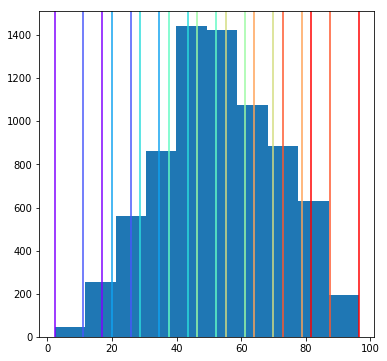

In [24]:
test_filter(np.array(data['CS01']).astype(float), 10, 40)

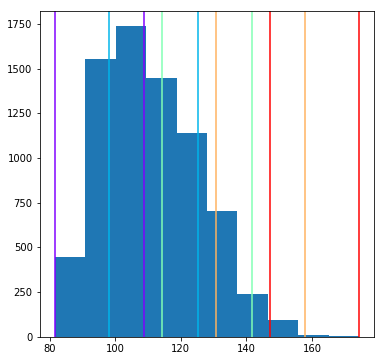

In [5]:
eccentricity_filter = mapper.filters.eccentricity(data)
test_filter(eccentricity_filter, 5, 40)

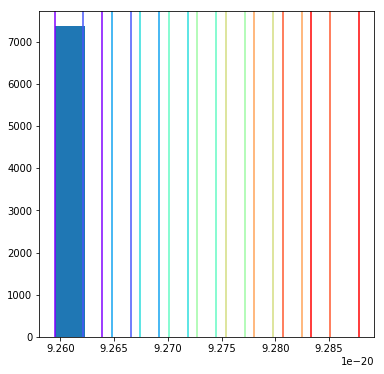

In [6]:
test_filter(mapper.filters.Gauss_density(data), 10, 40)

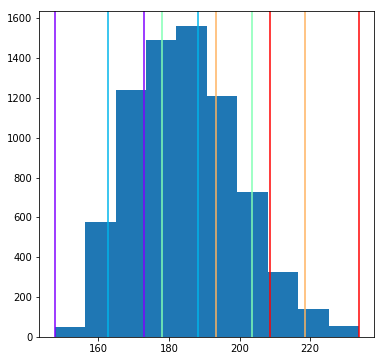

In [11]:
centrality_filter = l_infinity_centrality(data)
test_filter(centrality_filter, 5, 40)

Minimal epsilon: 7.23343.
Density of the adjacency matrix: 9.18%.
Eigenvalues: [1.42016932e-16 2.10094799e-02].


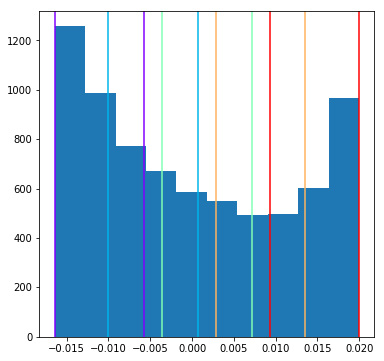

In [28]:
lap_filter = mapper.filters.graph_Laplacian(data[['CE01','CE02', 'CE03']], eps=12)
test_filter(lap_filter, 5, 40)

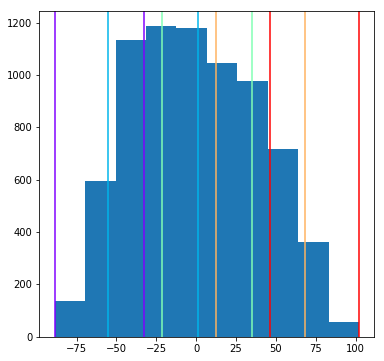

In [31]:
pca = PCA(n_components=2)
vals = pca.fit_transform(data)
test_filter(vals[:, 0], 5, 40)

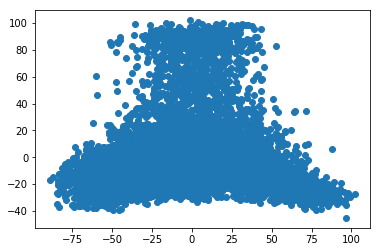

In [32]:
plt.scatter(vals[:, 0], vals[:, 1],)

In [56]:
knn_filter = mapper.filters.kNN_distance(data, k=2)

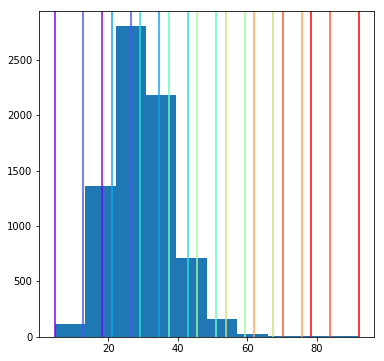

In [57]:
test_filter(knn_filter, 10, 40)

Filter level. Index: (0,), Range min: [4.56484019], Range max: [16.56070492]
Number of points in level - 419
Clusters -  13


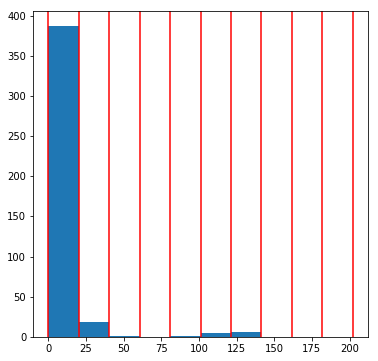

Filter level. Index: (1,), Range min: [12.9619455], Range max: [24.95781023]
Number of points in level - 2220
Clusters -  1


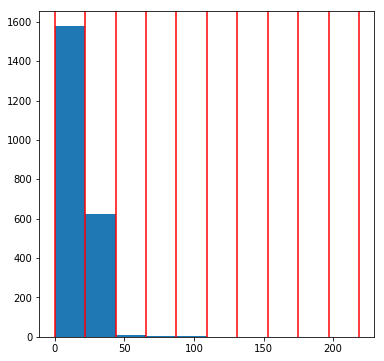

Filter level. Index: (2,), Range min: [21.35905081], Range max: [33.35491553]
Number of points in level - 3807
Clusters -  1


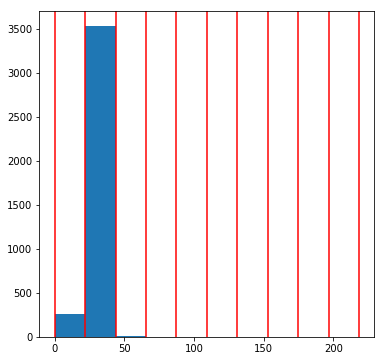

Filter level. Index: (3,), Range min: [29.75615612], Range max: [41.75202084]
Number of points in level - 2838
Clusters -  1


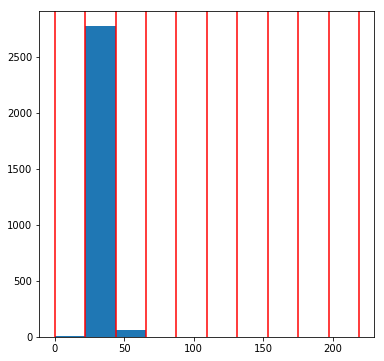

Filter level. Index: (4,), Range min: [38.15326142], Range max: [50.14912615]
Number of points in level - 1019
Clusters -  1


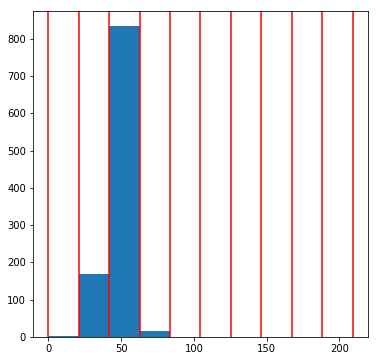

Filter level. Index: (5,), Range min: [46.55036673], Range max: [58.54623145]
Number of points in level - 256
Clusters -  1


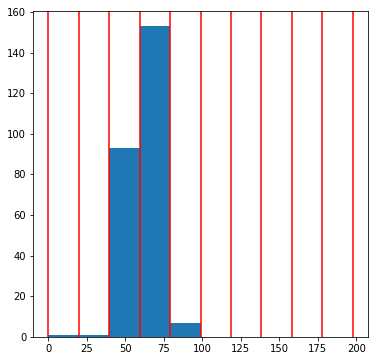

Filter level. Index: (6,), Range min: [54.94747204], Range max: [66.94333676]
Number of points in level - 49
Clusters -  49


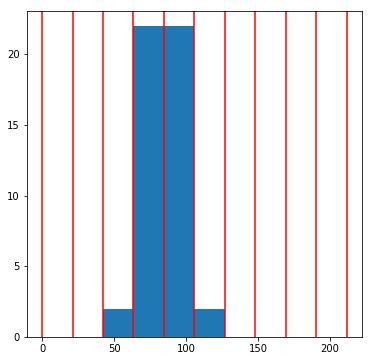

Filter level. Index: (7,), Range min: [63.34457734], Range max: [75.34044207]
Number of points in level - 13
Clusters -  13


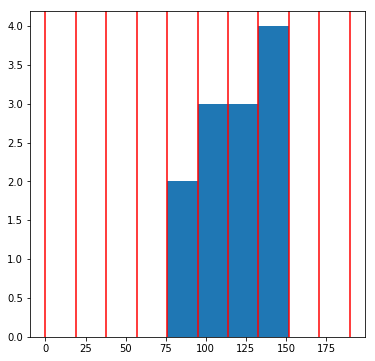

Filter level. Index: (8,), Range min: [71.74168265], Range max: [83.73754738]
Number of points in level - 10
Clusters -  10


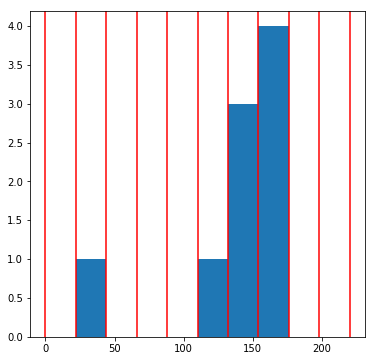

Filter level. Index: (9,), Range min: [80.13878796], Range max: [92.13465268]
Number of points in level - 5
Clusters -  5


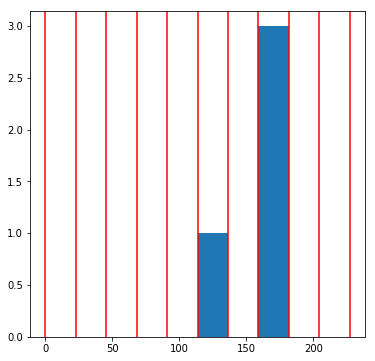

In [58]:
test_mapper_configuration(data, knn_filter, 10, 30, 10)

There are 96 nodes.


((-281.67, -289.6, 287.99999999999994, 252.0, 0.28766738322983026),
 array([ 0,  1,  9,  2,  3,  4, 12,  5, 15,  6, 20,  7, 18,  8, 19, 10, 33,
        11, 41, 13, 14, 16, 17, 21, 50, 22, 23, 52, 24, 25, 56, 26, 27, 71,
        28, 77, 29, 53, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44,
        45, 46, 47, 48, 49, 51, 54, 55, 59, 60, 62, 65, 66, 68, 69, 73, 74,
        75, 76, 92, 57, 58, 61, 63, 64, 67, 70, 72, 78, 79, 93, 80, 81, 82,
        83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95]),
 array([[ 168.    ,  132.    ],
        [   8.3196,  -38.395 ],
        [  -2.3196, -109.6   ],
        [-182.    , -108.    ],
        [-192.    , -168.    ],
        [  68.32  ,  -58.395 ],
        [  57.68  , -129.6   ],
        [ -51.68  ,  -38.395 ],
        [ -62.32  , -109.6   ],
        [-121.68  ,  -98.395 ],
        [-132.32  , -169.6   ],
        [ -71.68  , -168.4   ],
        [ -82.32  , -239.6   ],
        [ -11.68  , -168.4   ],
        [ -22.32  , -239.6   ],
        [ 108.32  

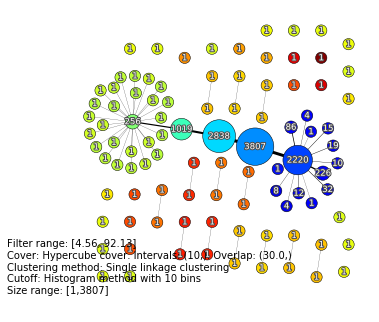

In [59]:
G = run_mapper(np.array(data).astype(float), knn_filter, 10, 30, 10)
G.draw_2D()

In [8]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(data)

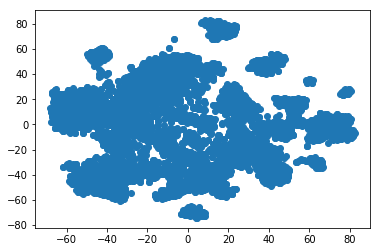

In [11]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],)

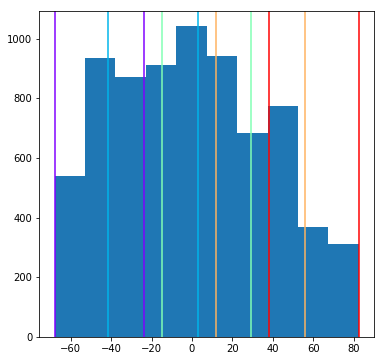

In [27]:
test_filter(X_embedded[:, 0], 5, 40)

Filter level. Index: (0,), Range min: [-68.00211334], Range max: [-23.71548866]
Number of points in level - 2293
Clusters -  2


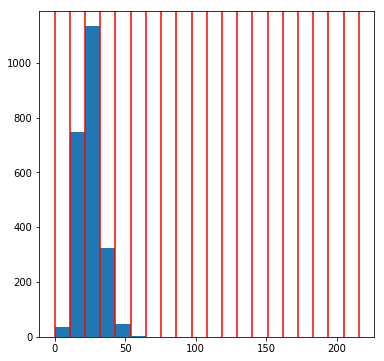

Filter level. Index: (1,), Range min: [-41.43013853], Range max: [2.85648615]
Number of points in level - 2761
Clusters -  2


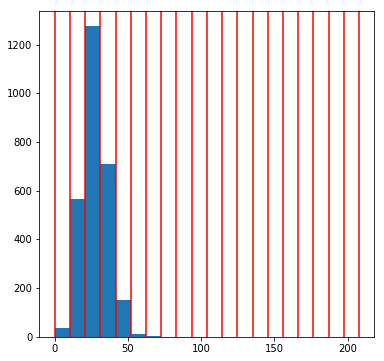

Filter level. Index: (2,), Range min: [-14.85816372], Range max: [29.42846096]
Number of points in level - 2786
Clusters -  1


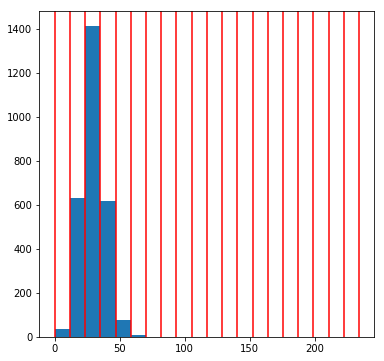

Filter level. Index: (3,), Range min: [11.71381109], Range max: [56.00043577]
Number of points in level - 2199
Clusters -  1


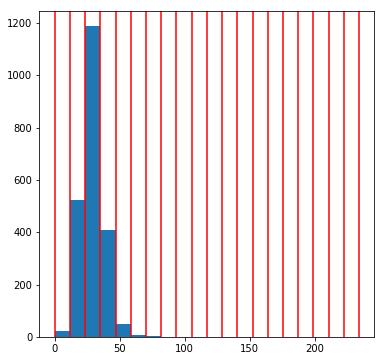

Filter level. Index: (4,), Range min: [38.2857859], Range max: [82.57241058]
Number of points in level - 1419
Clusters -  1


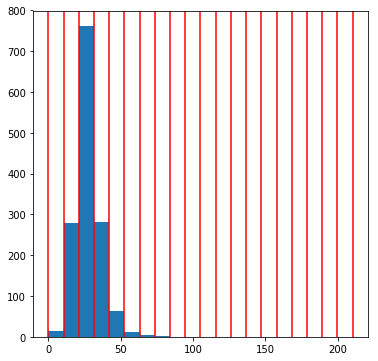

In [28]:
test_mapper_configuration(data, X_embedded[:, 0], 5, 40, 20)

There are 7 nodes.


((-110.34352231888946,
  -118.91630018401452,
  89.35884159801564,
  80.20085883742607,
  0.28766738322983026),
 array([0, 1, 4, 2, 3, 6, 5]),
 array([[-110.34352232,   80.20085884],
        [ -41.82254853,   53.12995275],
        [  31.35223859,   26.57133511],
        [ -40.07765779,  -17.74207841],
        [  73.65164248, -118.91630018],
        [  52.11015649,  -48.45334345],
        [  89.3588416 ,   80.20085884]]),
 <matplotlib.collections.CircleCollection at 0x7f7d6fd05080>)

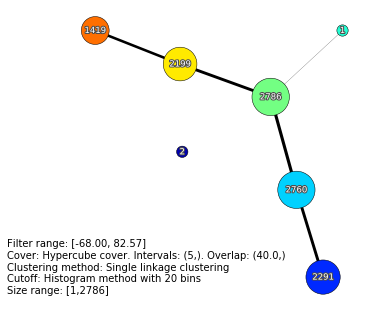

In [29]:
G = run_mapper(np.array(data).astype(float), X_embedded[:, 0].astype(float), 5, 40, 20)
G.draw_2D()

In [20]:
X_embedded[:, 0].shape

(7379,)